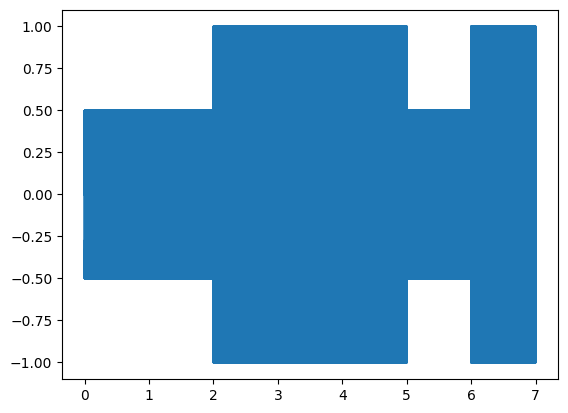

In [21]:
import numpy as np
import scipy
import scipy.signal as sp
import TC_Functions as TC
import matplotlib.pyplot as plt

def am_modulate(binary_message, fs = 44e3, fc = 10e3,  num_cycles = 10):

    fs = int(fs)
    fc = int(fc)

    # Convert binary message to square wave
    bit_duration = num_cycles / fc
    samples_per_bit = int(fs * bit_duration)
    
    # Create the square wave with the correct length
    square_wave = np.repeat(binary_message, samples_per_bit)
    
    # Generate the carrier wave with the correct length
    t = np.arange(len(square_wave)) / fs
    carrier = np.sin(2 * np.pi * fc * t)
    
    # Modulate the square wave
    modulated_signal = (1 + square_wave)/2 * carrier      # bit 0 -> 0.5, bit 1 -> 1
    return modulated_signal

data = np.random.randint(0, 2, 10)
data = np.r_[np.zeros(4), data]
modulated_am = am_modulate(data, 44e3, 1e3, 500)
scipy.io.wavfile.write('AM.wav', int(44e3), np.array(32760 * modulated_am, dtype=np.int16))
plt.plot(np.arange(len(modulated_am)) / 44e3, modulated_am)

TC.display_audio_signal(modulated_am)

In [61]:
def am_2b_modulate(binary_message, fs = 44e3, fc = 10e3,  num_cycles = 10):

    binary_message = np.array(binary_message)
    fs = int(fs)
    fc = int(fc)

    # Convert binary message to square wave
    bit_duration = num_cycles / fc
    samples_per_bit = int(fs * bit_duration)

    if len(binary_message) % 2 :
        binary_message = np.r_[binary_message, 0]

    packet = np.zeros(int(len(binary_message)/2))

    for i in range(0, len(binary_message), 2):
        packet[int(i/2)] = 2*binary_message[i] + binary_message[i+1]
    
    # Create the square wave with the correct length
    square_wave = np.repeat(packet, samples_per_bit)

    plt.plot(square_wave)
    
    # Generate the carrier wave with the correct length
    t = np.arange(len(square_wave)) / fs
    carrier = np.sin(2 * np.pi * fc * t)
    
    # Modulate the square wave
    modulated_signal = (2 + square_wave)/4 * carrier      # bit 0 -> 0.5, bit 1 -> 1
    return modulated_signal

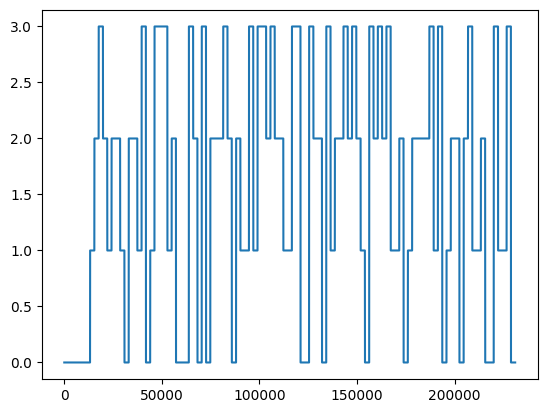

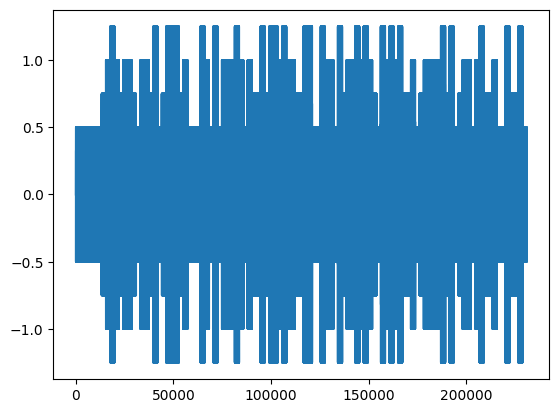

In [68]:
data = np.r_[np.zeros(10), np.random.randint(0, 2, 200)]

signal = am_2b_modulate(data, fs = 44e3, fc = 1e3,  num_cycles = 50)

plt.figure()
plt.plot(signal)
TC.display_audio_signal(signal)

In [70]:
import numpy as np
from scipy.signal import butter, filtfilt

class PLL:
    def __init__(self, wc: float, phase_gain: float, freq_gain: float, sf=None):
        self.wc = 2 * np.pi * wc / sf if sf else wc
        self.pg, self.fg = phase_gain, freq_gain
        self.freq_offset = 0
        self.nco_phase = 0

    def track(self, x: np.ndarray, ) -> np.ndarray:
        y = np.zeros(len(x))
        c = np.zeros(len(x))
        for n in range(0, len(x)):
            y[n] = np.cos(self.nco_phase)
            phase_offset = -x[n] * np.sin(self.nco_phase)
            self.freq_offset += self.fg * phase_offset
            c[n] = self.pg * phase_offset + self.freq_offset
            self.nco_phase += self.wc + c[n]
            # wrap the phase over the [0, 2\pi] interval
            self.nco_phase = (self.nco_phase + np.pi) % (2 * np.pi) - np.pi
        return y, c
    
def am_demodulate(modulated_signal, fs = 44e3, fc = 10e3, num_cycles = 10):

    fs = int(fs)
    fc = int(fc)
    
    bit_duration = num_cycles / fc
    samples_per_bit = int(fs * bit_duration)
    

    # normalize the signal amplitude by dividing by the 100th maximum value(added by mimmo02)-------------------------------------
    max = np.sort(np.abs(modulated_signal))[::-1][100]
    modulated_signal = modulated_signal / max

    # convert to mono the double channel signal if needed (added by @biofainapap)
    if len(modulated_signal.shape) > 1:
        modulated_signal = modulated_signal[:, 0]

    plt.figure()
    plt.plot(modulated_signal)
    plt.title("Normalized Modulated Signal")
    #---------------------------------------------------------------------------------------

    modulated_signal = 2*modulated_signal
    # Generate the carrier signal
    y, c = PLL(fc, 0.01, 0.01, fs).track(modulated_signal)
    
    # Demodulate the signal
    demodulated_signal = modulated_signal * y
    demodulated_signal = np.abs(demodulated_signal)
    
    plt.figure()
    plt.plot(demodulated_signal)
    plt.title("Demodulated Signal")
    plt.show()
    
    # Apply low-pass filter to the demodulated signal directly here
    normal_cutoff = fc/fs
    b, a = butter(5, normal_cutoff, btype='low', analog=False)
    filtered_demodulated_signal = filtfilt(b, a, demodulated_signal)
    
  
    
    # normalize the signal amplitude (added by mimmo02)-------------------------------------
    max = np.max(np.abs(filtered_demodulated_signal))
    filtered_demodulated_signal = filtered_demodulated_signal / max
    
    
    # calculate the mean par each bit
    means = []
    for i in range(0, len(filtered_demodulated_signal), samples_per_bit):
        means.append(np.mean(filtered_demodulated_signal[i:i+samples_per_bit]))
    
    # cancel the silence bits
    # caluculate the mean of 5 bits set
    
    part_means = []
    std = []
    
    for i in range(0, len(means), 5):
        group_mean = np.mean(means[i:i+5])
        # calculate the standard deviation of the group
        group_std = np.std(means[i:i+5])
        part_means.append(group_mean)
        std.append(group_std)
        
    std_mean = np.mean(std)
    part_means_mean = np.mean(part_means)   
        
    plt.figure()
    plt.plot(part_means)
    plt.plot(std)
    plt.plot([0, len(part_means)], [part_means_mean, part_means_mean], 'r')
    plt.plot([0, len(std)], [std_mean, std_mean], 'g')
    plt.title("Means and Standard Deviation")
    plt.show()
        
    # search for std < std_mean and part_means < part_means_mean
    del_num = 0
    for i in range(0, len(means), 5):
        if std[i//5] < std_mean and part_means[i//5] < part_means_mean:
            del_num += 5
        else:
            break
        
    filtered_demodulated_signal = filtered_demodulated_signal[del_num*samples_per_bit:]
    
    plt.figure()
    plt.plot(filtered_demodulated_signal)
    plt.title("Filtered Demodulated Signal without silence bits")
    plt.show()
    
            

    
    mean = np.mean(filtered_demodulated_signal)
    
    
    
    # plot the means for each bit
    plt.figure()
    plt.plot(filtered_demodulated_signal)
    # plot the means for each bit
    for i in range(min(len(filtered_demodulated_signal) // samples_per_bit, len(means))):
        plt.plot([i * samples_per_bit, (i + 1) * samples_per_bit], [means[i], means[i]], 'r')
    plt.plot([0, len(filtered_demodulated_signal)], [mean, mean], 'g')
    plt.title("Filtered Demodulated Signal")
    plt.show()
    
    
    
    #function to reduce the overshoot
    def sig_rescale(x,shift):
        up = np.arctan((10.0-shift)*50)
        down = np.arctan((-10.0-shift)*50)
        ampl = np.abs(up) + np.abs(down)
        y =  (np.arctan((x-shift)*50) + np.abs(down)) / ampl
        return y
    
     
    # rescale the bits depending on the mean value
    for i in range(0, len(filtered_demodulated_signal), samples_per_bit):
        #filtered_demodulated_signal[i:i+samples_per_bit] = sig_rescale(filtered_demodulated_signal[i:i+samples_per_bit], means[i//samples_per_bit])
        filtered_demodulated_signal[i:i+samples_per_bit] = sig_rescale(filtered_demodulated_signal[i:i+samples_per_bit], mean)
 
    
        

    
    plt.figure()
    plt.plot(filtered_demodulated_signal)
    plt.title("Levelled Signal")
    plt.show()
    
    #---------------------------------------------------------------------------------------
    
    # Convert the filtered demodulated signal back to binary data
    filtered_demodulated_signal = np.round(2 * filtered_demodulated_signal) - 1
    # set negative values to 0
    filtered_demodulated_signal[filtered_demodulated_signal < 0] = 0
    
    plt.figure()
    plt.plot(filtered_demodulated_signal)
    plt.title("Digitalized Demodulated Signal")
    plt.show()
    
    num_bits = len(filtered_demodulated_signal) // samples_per_bit
    binary_data = np.zeros(num_bits)

    for i in range(num_bits):
        segment = filtered_demodulated_signal[i * samples_per_bit:(i + 1) * samples_per_bit]
        binary_data[i] = 1 if np.mean(segment) > 0.5 else 0  # Use mean to determine bit value

    return binary_data.astype(int)

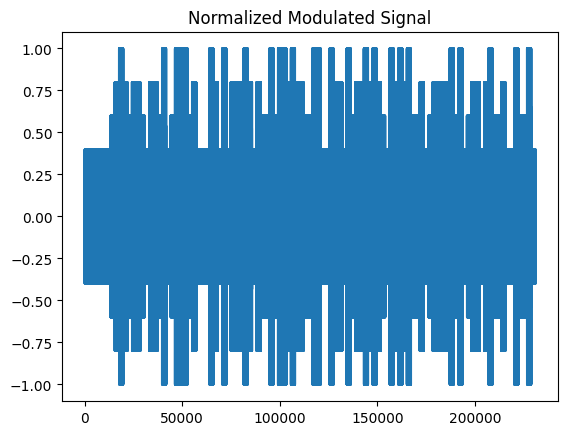

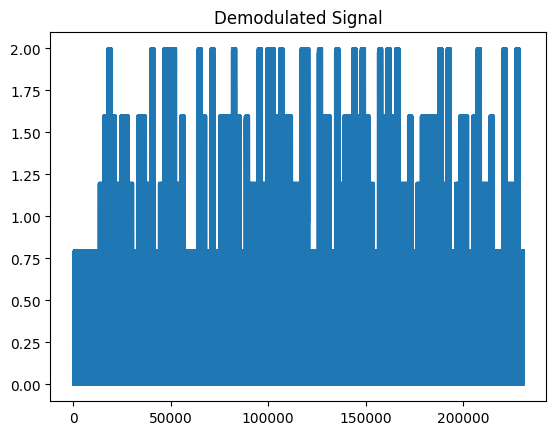

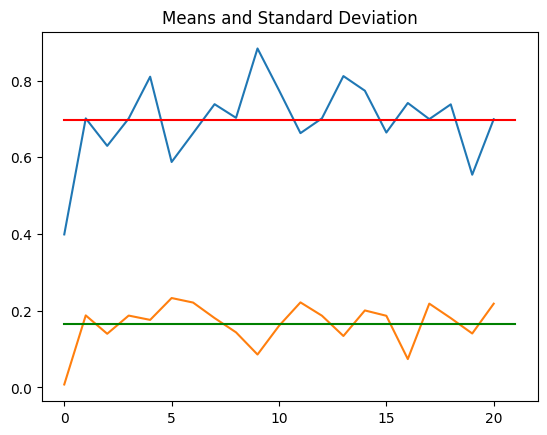

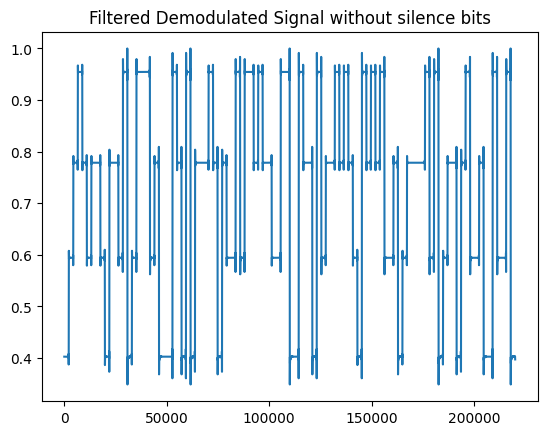

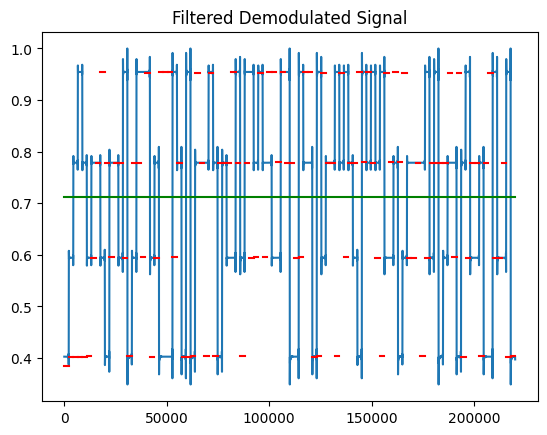

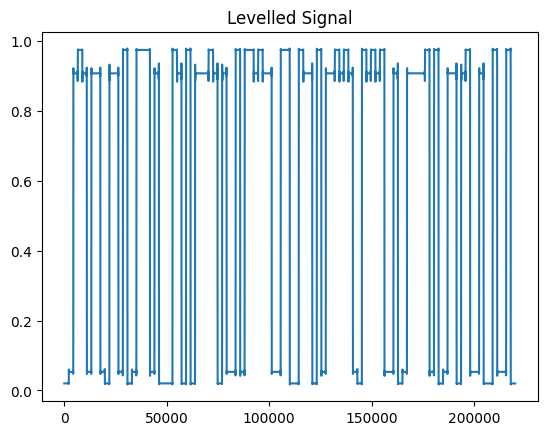

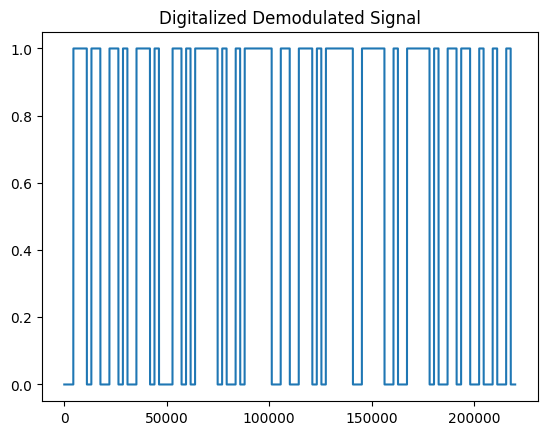

In [72]:
data_out = am_demodulate(signal, fs = 44e3, fc = 1e3,  num_cycles = 50)

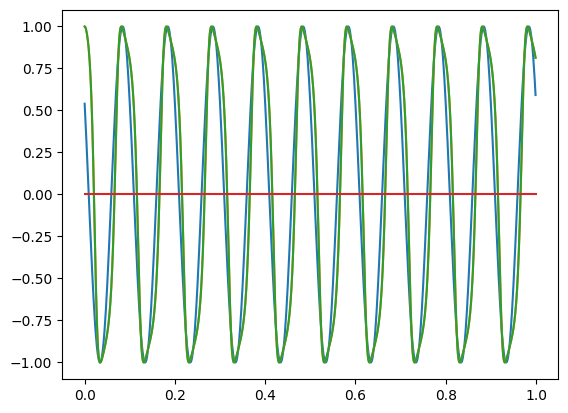

In [103]:
class PLL:
    def __init__(self, wc: float, phase_gain: float, freq_gain: float, sf=None):
        self.wc = 2 * np.pi * wc / sf if sf else wc
        self.pg, self.fg = phase_gain, freq_gain
        self.freq_offset = 0
        self.nco_phase = 0

    def track(self, x: np.ndarray, ) -> np.ndarray:
        y = np.zeros(len(x))
        c = np.zeros(len(x))
        for n in range(0, len(x)):
            y[n] = np.cos(self.nco_phase)
            phase_offset = -x[n] * np.sin(self.nco_phase)
            self.freq_offset += self.fg * phase_offset
            c[n] = self.pg * phase_offset + self.freq_offset
            self.nco_phase += self.wc + c[n]
            # wrap the phase over the [0, 2\pi] interval
            self.nco_phase = (self.nco_phase + np.pi) % (2 * np.pi) - np.pi
        return y, c
    
def PLL_function (input, fc, phase_gain, freq_gain, fs):
    wc = 2*np.pi*fc/fs
    act_phase = 0
    freq_offset = 0
    
    output = np.zeros(len(input))
    control = np.zeros(len(input))

    for i in range(len(input)) :
        output[i] = np.cos(act_phase)
        phase_offset = -input[i] * np.sin(act_phase)
        freq_offset = freq_offset + freq_gain * phase_offset
        control[i] = phase_gain * phase_offset + freq_offset
        act_phase = act_phase + wc + control[i]
        act_phase = (act_phase + np.pi) % (2 * np.pi) - np.pi

    return output


fc = 10
fs = 1000
t = np.arange(0, 10/fc, 1/fs)
x = np.cos(2*np.pi*10*t + 1)

y = PLL_function(x, fc, 0.1, 0, fs)
y2, c = PLL(fc, 0.1, 0, fs).track(x)

test = y - y2 

plt.plot(t, x)
plt.plot(t, y)
plt.plot(t, y2)
plt.plot(t, test)

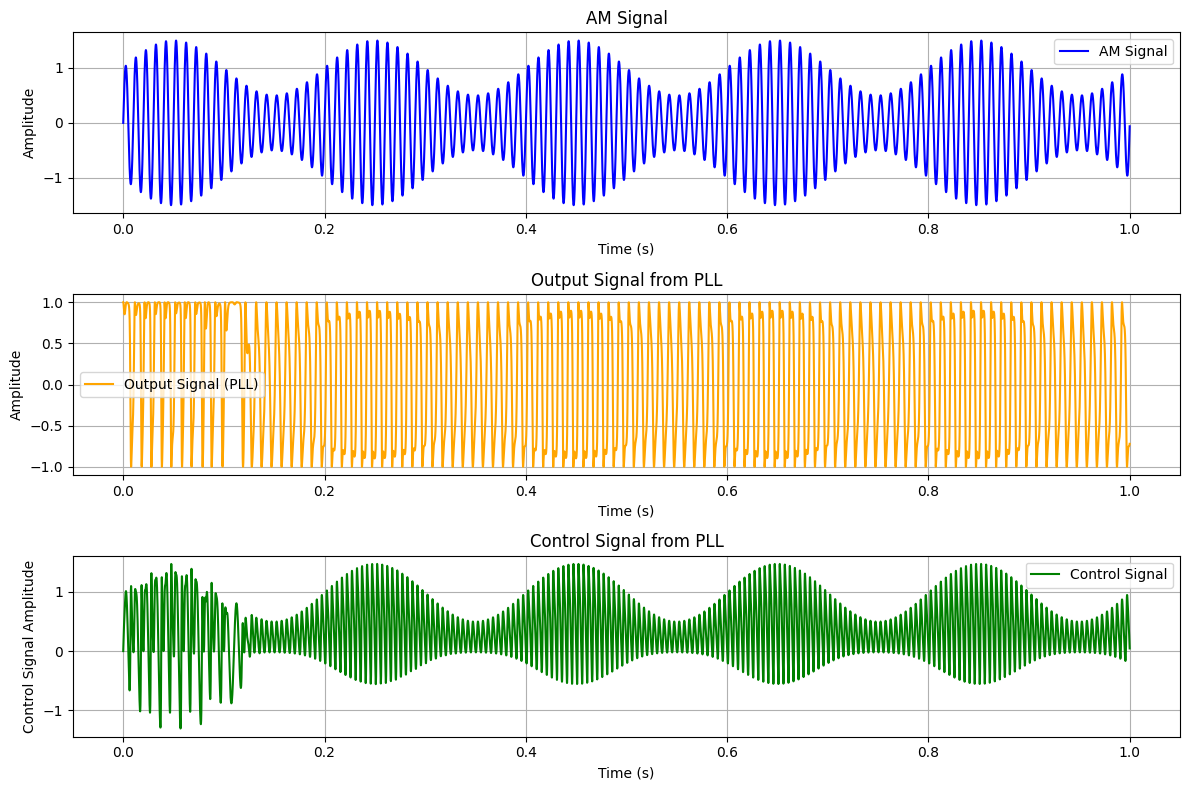

In [94]:
import numpy as np
import matplotlib.pyplot as plt

class PLL:
    def __init__(self, wc: float, phase_gain: float, freq_gain: float, sf=None):
        self.wc = 2 * np.pi * wc / sf if sf else wc  # Natural frequency
        self.pg, self.fg = phase_gain, freq_gain      # Gains
        self.freq_offset = 0                           # Frequency offset
        self.nco_phase = 0                             # NCO phase

    def track(self, x: np.ndarray) -> np.ndarray:
        y = np.zeros(len(x))  # Output signal
        c = np.zeros(len(x))  # Control signal
        for n in range(len(x)):
            y[n] = np.cos(self.nco_phase)  # Output of the NCO
            phase_offset = -x[n] * np.sin(self.nco_phase)  # Phase detector output
            self.freq_offset += self.fg * phase_offset  # Update frequency offset
            c[n] = self.pg * phase_offset + self.freq_offset  # Control signal
            self.nco_phase += self.wc + c[n]  # Update NCO phase
            # Wrap the phase over the [0, 2π] interval
            self.nco_phase = (self.nco_phase + np.pi) % (2 * np.pi) - np.pi
        return y, c  # Return the output and control signals

# Parameters for the AM signal
fs = 10000          # Sampling frequency (Hz)
T = 1               # Duration of the signal (seconds)
t = np.arange(0, T, 1/fs)  # Time vector

# AM signal parameters
fc = 100            # Carrier frequency (Hz)
fm = 5              # Modulating frequency (Hz)
Ac = 1              # Amplitude of the carrier
Am = 0.5            # Amplitude of the modulating signal

# Generate a message signal (modulating signal)
message_signal = Am * np.sin(2 * np.pi * fm * t)

# Generate the AM signal
am_signal = (Ac + message_signal) * np.sin(2 * np.pi * fc * t)

# Create PLL instance
pll = PLL(wc=fc, phase_gain=0.1, freq_gain=0.01, sf=fs)

# Track the carrier of the AM signal
output_signal, control_signal = pll.track(am_signal)

demodulate = output_signal*am_signal

# Plotting
plt.figure(figsize=(12, 8))

# AM signal
plt.subplot(3, 1, 1)
plt.plot(t, am_signal, label='AM Signal', color='blue')
plt.title('AM Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Output signal from PLL
plt.subplot(3, 1, 2)
plt.plot(t, output_signal, label='Output Signal (PLL)', color='orange')
plt.title('Output Signal from PLL')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Control signal
plt.subplot(3, 1, 3)
plt.plot(t, demodulate, label='Control Signal', color='green')
plt.title('Control Signal from PLL')
plt.xlabel('Time (s)')
plt.ylabel('Control Signal Amplitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()